# 题目1(10分）

## 问题描述

使用Adevrtising数据中的三个自变量(newpaper,TV和Radio)建立最小二乘法计算的多元回归模型和SO算法的多元回归模型并进行比较

## 解决目标/解题思路

* 读入数据集
* 筛选数据，查看数据情况(如是否存在NA)
* 导入对应第三方库并计算最小二乘多元回归结果
* 使用SO算法(如无第三方库需要自行编写)计算多元回归结果
* 比较两个模型系数结果

## 假设/引用

SO算法参考The Elements of Statistical Learning p54

## 代码实现

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#读取数据,分开每一列
df=pd.read_excel('Advertising.xlsx')
sales=df.loc[:,['Sales']].values  
tv=df.loc[:,['TV']].values
newspaper=df.loc[:,['Newspaper']].values
radio=df.loc[:,['Radio']].values
X=df.loc[:,['TV','Radio','Newspaper']].values

#建立多元回归模型
slr=LinearRegression() 
slr.fit(X,sales)
coef=slr.coef_.reshape(3,1)
print('建立的多元回归模型为y=%.3f*TV+%.3f*Radio%.3f*newspaper+%.3f'%(coef[0],coef[1],coef[2],slr.intercept_))


#逐步正交算法求解回归系数
#求解向量内积
def CalVecMul(a,b):
    sum=0
    for i in range(len(a)):
        sum+=a[i]*b[i]
    return sum

#SO算法的求解,X是3行矩阵，需要在原来基础上转置
def OSalg(X,y):  
    z=np.array([list(X[0])])   #第1项由1构成
    for j in [1,2,3]:
        sum0=np.array(list(np.zeros(len(y))))  #用来求线性组合
        for k in range(j):
            vector=(np.dot(X[j],z[k])/np.dot(z[k],z[k]))*z[k] 
            sum0+=vector
        z=np.append(z,np.array([list(X[j]-sum0)]),axis=0)
    return np.dot(y.reshape(200),z[3])/np.dot(z[3],z[3])

#求解Newspaper的系数,在最前面添加1列1
X1=np.c_[np.ones(200),X].T
b3=OSalg(X1,sales)
#求解Radio的系数
X2=df.loc[:,['TV','Newspaper','Radio']].values
X2=np.c_[np.ones(200),X2].T
b2=OSalg(X2,sales)
#求解TV的系数
X3=df.loc[:,['Newspaper','Radio','TV']].values
X3=np.c_[np.ones(200),X3].T
b1=OSalg(X3,sales)
#求解常数项
X4=np.c_[X,np.ones(200)].T
a=OSalg(X4,sales)
print('依据SO算法建立的多元回归模型为y=%.3f*TV+%.3f*Radio%.3f*newspaper+%.3f'%(b1,b2,b3,a))

建立的多元回归模型为y=0.046*TV+0.189*Radio-0.001*newspaper+2.939
依据SO算法建立的多元回归模型为y=0.046*TV+0.189*Radio-0.001*newspaper+2.939


## 结果分析

计算发现最小二乘法和SO算法得出的回归方程是一致的。通过最小二乘回归计算出的多元回归系数与通过逐步正交回归(Successive Orthogonalization)得到的回归系数完全一致，因此这两种方法是等效的，即多元回归中，某一自变量的回归系数可以解释为在排除其他自变量对因变量的影响后该自变量仍然能够对因变量产生的影响。

对于题目1一共10分的分值，1.1-1.3占3分，1.4代码实现处共占5分，其中合适注释2分，训练集测试集划分1分(如有)，代码完成程度(2分),1.5结果解释2分

# 第二题

## 问题描述

用sa心脏病数据，用chd(1:得病，0：正常)，对tobacco(吸烟量)+ldl(肥胖指数)+age(年龄)进行logistic回归建模，并和用FisherLDA进行比较，实验中P(Ci),i=1,2,3,请用每一组参与训练的数据量来估计

## 解决目标/解题思路

* 读入数据集
* 筛选数据，查看数据情况(如是否存在NA)
* 进行训练集、测试集的划分
* 导入所需的第三方库并在训练集上进行logistic回归
* 使用FisherLDA算法(如无第三方库需要自行编写)在训练集上训练
* 使用两个模型在测试集上进行预测，比较两个模型在测试集上的结果

## 假设/引用

fisher线性判别算法参考PPT《第四章 分类线性模型》p36

## 代码实现

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#读入数据集并查看
saheart=pd.read_csv("saheart.csv")
print(saheart)

#提取对应变量
x1=saheart.values[:,0].astype(float)
x2=saheart.values[:,1].astype(float)
x3=saheart.values[:,5].astype(float)
y=saheart.values[:,6]



     tobacco    ldl  famhist  obesity  alcohol  age  Class
0      12.00   5.73        1    25.30    97.20   52      2
1       0.01   4.41        2    28.87     2.06   63      2
2       0.08   3.48        1    29.14     3.81   46      1
3       7.50   6.41        1    31.99    24.26   58      2
4      13.60   3.50        1    25.99    57.34   49      2
..       ...    ...      ...      ...      ...  ...    ...
457     0.40   5.98        2    28.45     0.00   58      1
458     4.20   4.41        2    28.61    18.72   52      2
459     3.00   1.59        2    20.09    26.64   55      1
460     5.40  11.61        2    27.35    23.97   40      1
461     0.00   4.82        1    14.70     0.00   46      2

[462 rows x 7 columns]


In [38]:
#统计各类别所占数目
i=0
length=0
while(i<462):
    if y[i]==1:
        length=length+1
    i=i+1
print(length)

302


In [39]:
#划分训练集和测试集：第一类采用前242个作为训练集，其余作为测试集；第二类采用前100个作为训练集，其余作为测试集

#先将数据分类处理：
i=0
length1=0
length2=0
type1=np.zeros([length,3])
type2=np.zeros([462-length,3])
while(i<462):
    if y[i]==1:
        type1[length1,0]=x1[i]
        type1[length1,1]=x2[i]
        type1[length1,2]=x3[i]
        length1=length1+1
    else:
        type2[length2,0]=x1[i]
        type2[length2,1]=x2[i]
        type2[length2,2]=x3[i]
        length2=length2+1
    i=i+1
#划分训练集和测试集
train1=type1[0:242,:]
test1=type1[242:302,:]
train2=type2[0:100,:]
test2=type2[100:160,:]

** fisherLDA线性判别 **

In [40]:
#使用fisherLDA线性判别，求基本元素：
#均值向量
mean1=np.mean(train1,axis=0)
mean2=np.mean(train2,axis=0)
#类内协方差矩阵
deta1=np.zeros([3,3])
deta2=np.zeros([3,3])
print(deta1)
i=0
while(i<len(train1)):
    hh=train1[i,:]-mean1
    deta1=np.dot(hh.reshape(3,1),hh.reshape(1,3))+deta1
    i=i+1
i=0
while(i<len(train2)):
    hh=train2[i,:]-mean2
    deta2=np.dot(hh.reshape(3,1),hh.reshape(1,3))+deta2
    i=i+1


print('正例均值向量:',mean1)
print('反例均值向量:',mean2)
print('正例协方差矩阵:\n',deta1)
print('反例协方差矩阵:\n',deta2)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
正例均值向量: [ 2.65793388  4.35268595 38.97107438]
反例均值向量: [ 5.5482  5.5122 49.59  ]
正例协方差矩阵:
 [[ 3023.98916694   362.89784298  6348.51553719]
 [  362.89784298   829.99375413  1936.95880165]
 [ 6348.51553719  1936.95880165 52794.79752066]]
反例协方差矩阵:
 [[ 2962.511076  -108.039104  1494.9562  ]
 [ -108.039104   445.911316   445.1002  ]
 [ 1494.9562     445.1002   11672.19    ]]


In [41]:
#求解Fisher判别中的权重
deta12=deta1+deta2
w12=np.dot(np.linalg.inv(deta12),mean1-mean2)
print('权重为:',w12)
#求解Fisher判别中的阈值：
T=0.5*np.dot(np.dot((mean1+mean2),np.linalg.inv(deta12)),mean1-mean2)
print('阈值为:',T)

权重为: [-0.00032217 -0.00065529 -0.00010131]
阈值为: -0.009040053839360386


In [42]:
#求解错判数目

result1=np.arange(0,60,1)
i=0
wrong1=0
while(i<60):
    zz=np.array(test1[i,:])
    z=np.dot(w12,test1[i,:])
    if z>T:
        result1[i]=1
    else:
        result1[i]=2
        wrong1=wrong1+1
    i=i+1
print('Fisher在类型1中判别结果为:',result1)
print("Fisher在类型1中错误判别的个数为：",wrong1)

result2=np.arange(0,60,1)
wrong2=0
i=0
while(i<60):
    z=np.dot(w12,test2[i,:])
    if z>T:
        result2[i]=1
        wrong2=wrong2+1
    else:
        result2[i]=2
    i=i+1
print('Fisher在类型2中判别结果为:',result2)
print("Fisher在类型2中错误判别的个数为：",wrong2)

Fisher在类型1中判别结果为: [1 1 1 1 1 2 1 2 1 1 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 2]
Fisher在类型1中错误判别的个数为： 15
Fisher在类型2中判别结果为: [1 2 2 1 1 2 1 2 1 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 1 1 2 2 1 1 2 2 1 1 2 1]
Fisher在类型2中错误判别的个数为： 18


In [43]:
print("Fisher判别器的错误率为：",(wrong1+wrong2)/120)

Fisher判别器的错误率为： 0.275


** Logistic **

In [54]:
#使用logistic回归
x=np.zeros((342,3))
y=np.arange(342).reshape(-1,1)
y=np.ravel(y)  #扁平化函数
i=0

#对训练集和测试集分别进行合并调整
while(i<242):
    x[i]=train1[i]
    y[i]=1
    i=i+1
i=242
while(i<342):
    x[i]=train2[i-242]
    y[i]=2
    i=i+1
    
xtest1=test1
ytest1=np.ones(60).reshape(-1,1)
ytest1=np.ravel(ytest1)


xtest2=test2
ytest2=np.ones(60).reshape(-1,1)
ytest2=np.ravel(ytest2)


In [60]:
#建立logistic回归
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(C=10)
model.fit(x,y)

#进行预测
result1=model.predict(xtest1)
result2=model.predict(xtest2)
print("logistic对模型一测试点的预测结果为：")
print(result1)
i=0
wrong1=0
while(i<60):
    if result1[i]==2:
        wrong1=wrong1+1
    i=i+1
print("其中预测错误的点的个数为：",wrong1)
print("logistic对模型二测试点的预测结果为：")
print(result2)
i=0
wrong2=0
while(i<60):
    if result2[i]==1:
        wrong2=wrong2+1
    i=i+1
print("其中预测错误的点的个数为：",wrong2)
xtest=np.append(xtest1,xtest2,axis=0)
ytest=np.append(ytest1,ytest2,axis=0)
score=model.score(xtest,ytest)
print("logistic的模型得分为：",score)
print("logistic模型的错误率为：",(wrong1+wrong2)/120)

logistic对模型一测试点的预测结果为：
[1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2]
其中预测错误的点的个数为： 6
logistic对模型二测试点的预测结果为：
[1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 2 2 1 1 1 1 1 1 1 2 2 1 2 1 2 1 1 1 2
 1 1 1 1 2 1 1 2 2 2 2 1 1 2 1 1 1 1 1 1 1 1 1]
其中预测错误的点的个数为： 42
logistic的模型得分为： 0.8
logistic模型的错误率为： 0.4


## 结果分析

由上述结果可以看出，使用FisherLDA进行预测时，错误率为0.275；

使用logistic回归进行预测试时，错误率为0.4，高于FisherLDA

通过详细预测结果还发现，logistic回归错判1为2的可能性较小，将2错判为1的可能性较大

可能对于类别数目不均衡的样本，logistic比FisherLDA受到的影响更大

# 第三题

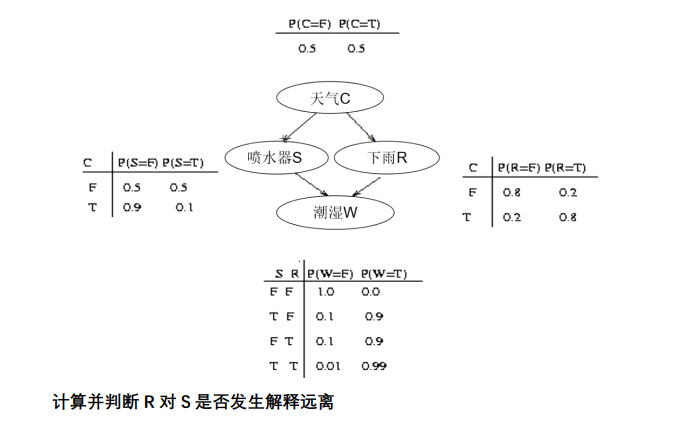

## 问题描述

R对W是否存在解释远离？

## 解决目标/解题思路

思路：如果发生了解释远离，则需要满足不等式：P(R=t|W=t,S=t)<P(R=t|W=t),即S的发生会使R对W的解释力下降

## 假设/引用

解释远离的参考来自xxxxx

## 代码实现

**计算条件分布P(R=t|W=t)**

In [65]:
# 刘心怡 2020200801
#变量解释：  Pcs1=P(S=t|C=t);   Pcs2=P(S=f|C=t);  Pcs3=P(S=t|C=f);  Pcs4=P(S=f|C=f);  Pcr1=P(R=t|C=t);  Pcr2=P(R=f|C=t);  Pcr3=P(R=t|C=f);  Pcr4=P(R=f|C=f);Pc1=P(C=t);  Pc2=P(C=f)
pc1=0.5
pc2=0.5
pcs1=0.1
pcs2=0.9
pcs3=0.5
pcs4=0.5
pcr1=0.8
pcr2=0.2
pcr3=0.2
pcr4=0.8

In [66]:
pst=pc1*pcs1+pc2*pcs3  #pst=P(S=t)
prt=pc1*pcr1+pc2*pcr3  #prt=P(R=t)

In [67]:
#P(S=t,R=t)=P(S=t,R=t|C=t)*P(C=t)+P(S=t,R=t|C=f)*P(C=f)
#根据条件独立性：P(S=t,R=t)=P(S=t|C=t)*P(R=t|C=t)*P(C=t)+P(S=t|C=f)*P(R=t|C=f)*P(C=f)
#同理有：
#P(S=t,R=f)=P(S=t|C=t)*P(R=f|C=t)*P(C=t)+P(S=t|C=f)*P(R=f|C=f)*P(C=f)
#P(S=f,R=t)=P(S=f|C=t)*P(R=t|C=t)*P(C=t)+P(S=f|C=f)*P(R=t|C=f)*P(C=f)
#P(S=f,R=f)=P(S=f|C=t)*P(R=f|C=t)*P(C=t)+P(S=f|C=f)*P(R=f|C=f)*P(C=f)

#变量解释：Psr1=P(S=t,R=t); Psr2=P(S=t,R=f);  Psr3=P(S=f,R=t);  Psr4=P(S=f,R=f);
psr1=pcs1*pcr1*pc1+pcs3*pcr3*pc2
psr2=pcs1*pcr2*pc1+pcs3*pcr4*pc2
psr3=pcs2*pcr1*pc1+pcs4*pcr3*pc2
psr4=pcs2*pcr2*pc1+pcs4*pcr4*pc2
print(psr1)
print(psr2)
print(psr3)
print(psr4)

0.09000000000000001
0.21000000000000002
0.41000000000000003
0.29000000000000004


In [69]:
#变量解释：P1=P(W=t);  P2=P(R=t,W=t); 

#P(W=t)=P(W=t|S=t,R=t)*P(S=t,R=t)+P(W=t|S=t,R=f)*P(S=t,R=f)+P(W=t|S=f,R=t)*P(S=f,R=t)+P(W=t|S=f,R=f)*P(S=f,R=f)
p1=0.99*psr1+0.9*psr2+0.9*psr3+0*psr4
print(p1)

#P(W=t,R=t)=P(W=t,R=t,S=t)+P(W=t,R=t,S=f)=P(W=t|R=t,S=t)*P(R=t,S=t)+P(W=t\R=t,S=f)*P(R=t,S=f)
p2=0.99*psr1+0.9*psr3
print(p2)

0.6471
0.45810000000000006


In [70]:
p=p2/p1
print('P(R=t|W=t)=',p)

P(R=t|W=t)= 0.7079276773296246


**计算条件分布P(R=t|W=t,S=t)**

In [71]:
#变量解释：P(R=t|W=t,S=t)=P(W=t,R=t,S=t)/P(W=t,S=t)，记p3=P(W=t,R=t,S=t)，p4=P(W=t,S=t)

#P(W=t,S=t,R=t)=P(W=t|S=t,R=t)*P(S=t,R=t)
p3=0.99*psr1

#P(W=t,S=t)=P(W=t,S=t,R=t)+P(W=t,S=t,R=f)=P(W=t|S=t,R=t)*P(S=t,R=t)+P(W=t|S=t,R=f)*P(S=t,R=f)
p4=0.99*psr1+psr2*0.9

p0=p3/p4
print('P(R=t|W=t,S=t)=',p0)

P(R=t|W=t,S=t)= 0.32038834951456313


## 结果分析

因为P(R=t|W=t,S=t)=0.32038834951456313，P(R=t|W=t)=0.7079276773296246

P(R=t|W=t,S=t)<P(R=t|W=t),所以认为发生了解释远离现象

## 其他实现

In [74]:
#代码实现2 杨佩霏 2020200891

# 准备工作-导入库

import pandas as pd
import numpy as np
import math

# 一、定义计算相关概率的各种函数

## 1.计算一个事件条件概率的函数 P(A|B)

def condition_rate1(p_a_with_b, p_b):
    
    p_a_from_b = p_a_with_b / p_b
    
    return p_a_from_b

## 2.计算两个事件条件概率的函数 P(A|B,C)

def condition_rate2(p_a_b_and_c, p_b_with_c):
    
    p_a_from_b_and_c = p_a_b_and_c / p_b_with_c
    
    return p_a_from_b_and_c

## 3.计算第二层节点【发生】的概率的函数，即全概率公式

### 传入参数：m1-父节点的概率矩阵 m2-当前节点的概率矩阵
def node_rate2(m1, m2):
    
#     print(m2[0][1] , m1[0][0] , m2[1][1] , m1[0][1])
    P = m2[0][1] * m1[0][0] + m2[1][1] * m1[0][1]
    
    return P

## 4.计算第三层节点【发生】的概率的函数，即全概率公式
### P(W=T) = P(W=T|S=T,R=T)*P(S=T,R=T)+ P(W=T|S=T,R=F)*P(S=T,R=F)+ P(W=T|S=F,R=T)*P(S=F,R=T)+ P(W=T|S=F,R=F)*P(S=F,R=F)
## P(S=T,R=T) = P(C=T)*P(S=T|C=T)*P(R=T|C=T) + P(C=F)*P(S=T|C=F)*P(R=T|C=F)
## 其他同理
### 传入参数：p-最上层节点的发生概率 m1-上层节点一的发生概率 m2-上层节点二的发生概率 m-当前节点的概率矩阵
def node_rate3(p, m1, m2, m):
    
    P = m[3][1]*(p*m1[1][1]*m2[1][1]+(1-p)*m1[0][1]*m2[0][1]) + m[2][1]*(p*m1[1][0]*m2[1][1]+(1-p)*m1[0][0]*m2[0][1]) + m[1][1]*(p*m1[1][1]*m2[1][0]+(1-p)*m1[0][1]*m2[0][0]) + m[0][1]*(p*m1[1][0]*m2[1][0]+(1-p)*m1[0][0]*m2[0][0])
    
    return P


## 5.利用条件独立公式计算三个事件的联合概率

## P(R=T,S=T,W=T) = P(W=T|S=T,R=T)*P(S=T,R=T)
## 其中 P(S=T,R=T) = P(C=T)*P(S=T,R=T|C=T) + P(C=F)*P(S=T,R=T|C=F)
## 由条件独立性得 P(S=T,R=T|C=T) = P(S=T|C=T)*P(R=T|C=T)
## 同理 P(S=T,R=T|C=F) = P(S=T|C=F)*P(R=T|C=F)

### 传入参数：p0-最上层节点的发生概率 m1,m2-节点的概率矩阵 m3-最后节点的概率矩阵
def together_rate3(p0, m1, m2, m3):
    
    P = m3[3][1]*( p0*m1[1][1]*m2[1][1] + (1-p0)*m1[0][1]*m2[0][1] )
    return P

## 6.利用条件独立公式计算两个事件的联合概率

## 例如 P(S,W) = P(S=T,W=T,R=T) + P(S=T,W=T,R=F)
## P(S=T,W=T,R=F)计算同上
## P(R=F,S=T,W=T) = P(W=T|S=T,R=F)*P(S=T,R=F)
## 其中 P(S=T,R=F) = P(C=T)*P(S=T,R=F|C=T) + P(C=F)*P(S=T,R=F|C=F)
## 由条件独立性得 P(S=T,R=F|C=T) = P(S=T|C=T)*P(R=F|C=T)
## 同理 P(S=T,R=F|C=F) = P(S=T|C=F)*P(R=F|C=F)

## 例如 P(R,W) = P(S=T,W=T,R=T) + P(S=F,W=T,R=T)
## P(S=F,W=T,R=T)计算同上
## P(R=T,S=F,W=T) = P(W=T|S=F,R=T)*P(S=F,R=T)
## 其中 P(S=F,R=T) = P(C=T)*P(S=F,R=T|C=T) + P(C=F)*P(S=F,R=T|C=F)
## 由条件独立性得 P(S=F,R=T|C=T) = P(S=F|C=T)*P(R=T|C=T)
## 同理 P(S=F,R=T|C=F) = P(S=F|C=F)*P(R=T|C=F)

### 传入参数：p0-最上层节点的发生概率 m1,m2-节点的概率矩阵 m3-最后节点的概率矩阵
def together_rate2(p0, m1, m2, m3, a):
    
    p1 = together_rate3(p0, m1, m2, m3)
    if(a == 'SW'):
        p2 = m3[1][1]*( p0*m1[1][1]*m2[1][0] + (1-p0)*m1[0][1]*m2[0][0] )
    elif(a == 'RW'):
        p2 = m3[2][1]*( p0*m1[1][0]*m2[1][1] + (1-p0)*m1[0][0]*m2[0][1] )
    P = p1 + p2
    return P

# 二、定义题目所给贝特斯网络中的概率矩阵

C = [[0.5,0.5]]
S_C = [[0.5,0.5],[0.9,0.1]]
R_C = [[0.8,0.2],[0.2,0.8]] 
W_SR = [[1.0,0.0],[0.1,0.9],[0.1,0.9],[0.01,0.99]]

# print(W_SR[0][1]) # 测试输出


# 三、计算各节点的发生概率

St = node_rate2(C, S_C)
Rt = node_rate2(C, R_C)
Wt = node_rate3(C[0][1], S_C, R_C, W_SR)

print('S，R，W的发生概率:',St,Rt,Wt)


# 四、计算解释远离的条件：P(R|S,W) ?= P(R|W)
## P(R|S,W) = P(R,S,W)/P(S,W)
## P(R|W) = P(R,W)/P(W)

P_RSW = together_rate3(C[0][1], S_C, R_C, W_SR)
P_SW = together_rate2(C[0][1], S_C, R_C, W_SR, 'SW')
P_RW = together_rate2(C[0][1], S_C, R_C, W_SR, 'RW')
P_W = Wt

P_R_SW = condition_rate2(P_RSW, P_SW)
P_R_W = condition_rate1(P_RW, P_W)

print('SW均发生、RW均发生的联合概率:',P_SW,P_RW)

print('P(R|S,W)=',P_R_SW)
print('P(R|W)=',P_R_W)

S，R，W的发生概率: 0.3 0.5 0.6471000000000001
SW均发生、RW均发生的联合概率: 0.2781 0.45810000000000006
P(R|S,W)= 0.32038834951456313
P(R|W)= 0.7079276773296245


答：由结果可知，P(R|S,W) < P(R|W)，说明在这种情况下，对于事件W发生的前置事件S，R，未观察S时R的后验概率大于观察S后R的后验概率，即证据增A加并未导致信念增加，也就是R对W发生了解释远离。